# Analyse av manglende værdata
Denne notebooken benytter klasser fra missingData og visualiserer manglende værmålinger både statisk
og interaktivt ved hjelp av Plotly, MissingNo og Dash.

## Felles import for alle kodeblokker

In [1]:
import dash
import plotly.express as px
import sys
import warnings

from dash import html, dcc, Input, Output

sys.path.append("../../src/missingData")

from missingdatavisualizer import MissingDataVisualizer
from missingdatafinder import MissingDataConverter

warnings.filterwarnings(
    "ignore",
    message="Format strings passed to MaskedConstant",
)

viz = MissingDataVisualizer(
    "../../data/missing/missing_in_both.csv",
)

## Statisk visualisering av mengde

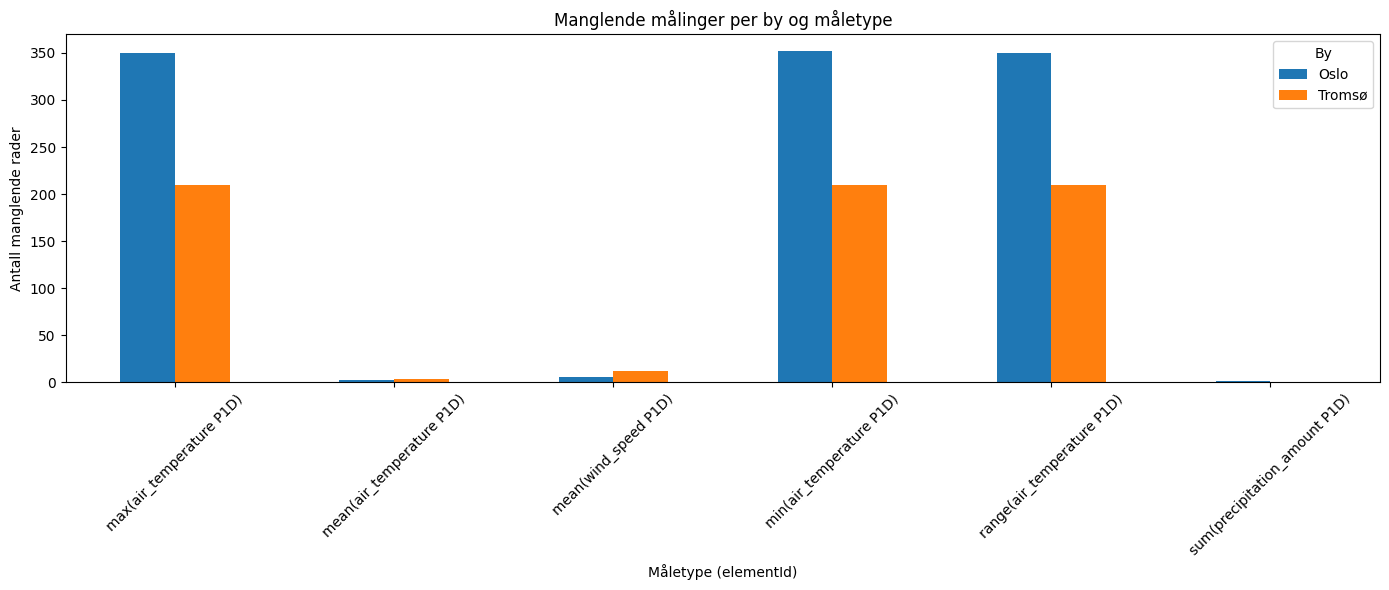

In [2]:
viz.plot_summary_bar(figsize=(14,6))

## Korrelasjonsvarmekart for manglende data

Heatmap for Oslo


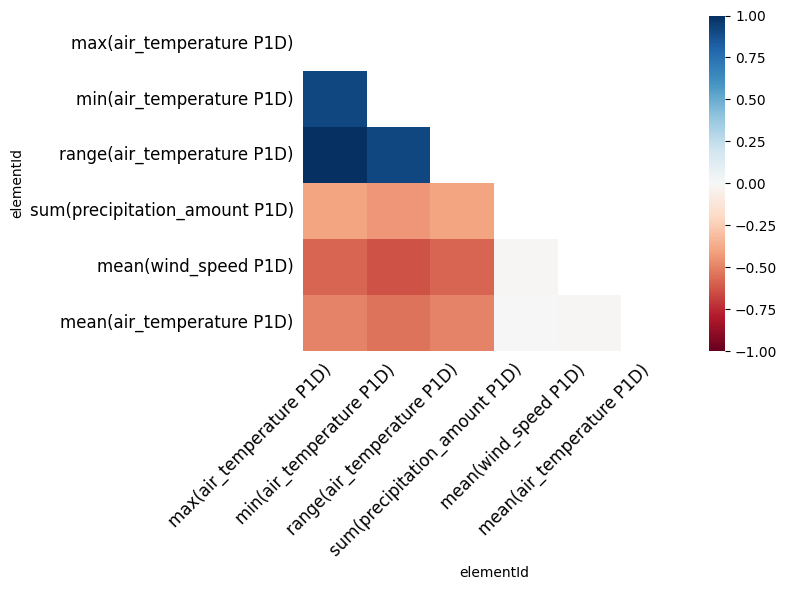

Heatmap for Tromsø


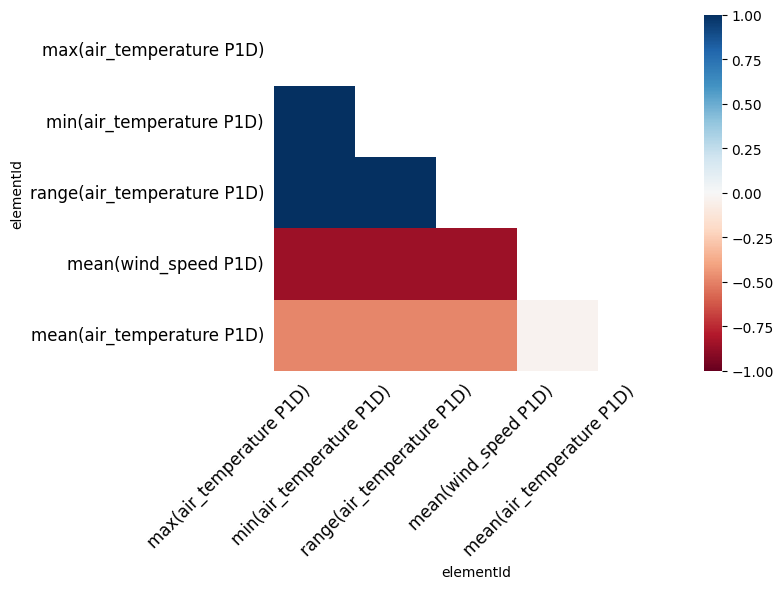

In [3]:
for city in ['Oslo', 'Tromsø']:
    print(f"Heatmap for {city}")
    viz.plot_heatmap(city, figsize=(8,6), fontsize=12)

## Tidslinje av manglende data

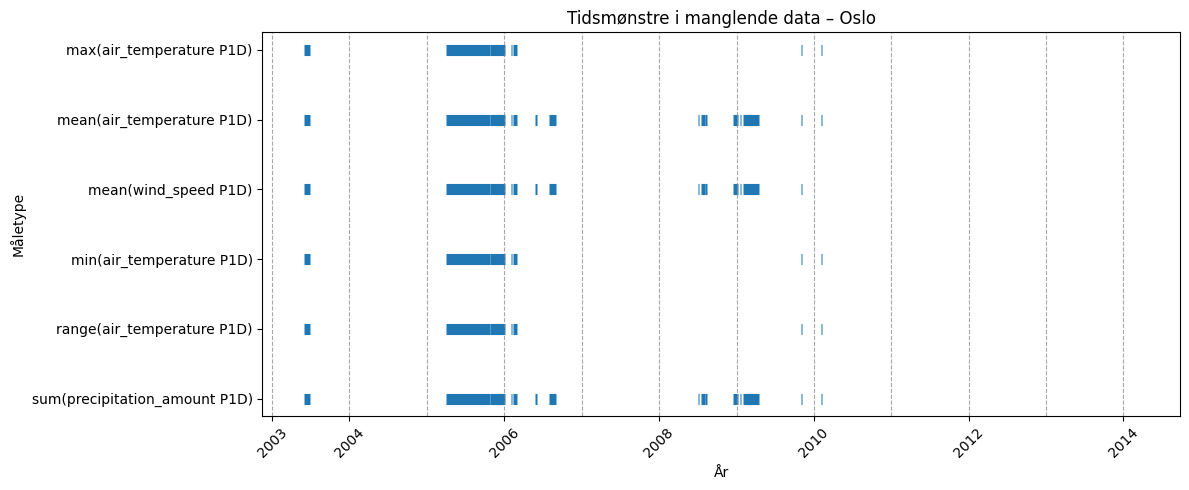

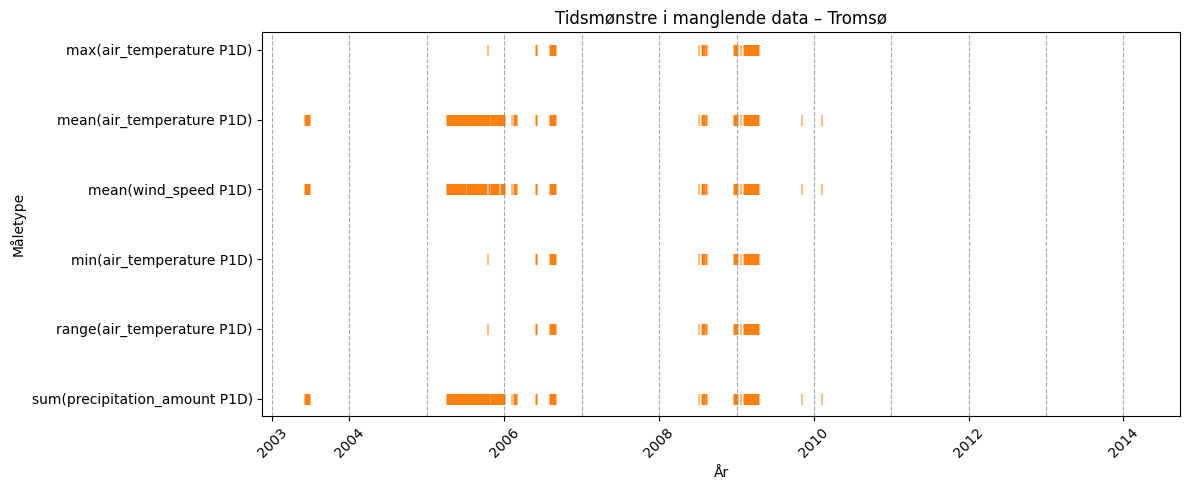

In [4]:
for city in ['Oslo', 'Tromsø']:
    viz.plot_missing_timeline(city, figsize=(12,5), line_width=8)

## Interaktiv visualisering med Dash

In [5]:
converter = MissingDataConverter()
df_summary = (
    converter.read_missing_values(
        "../../data/missing/missing_in_both.csv"
    )
    .assign(
        elementId=lambda df: df["elementId"].astype(str).str.strip(),
        city=lambda df: df["missing"].astype(str).str.strip(),
    )
    .groupby(["city", "elementId"], as_index=False)
    .size()
    .rename(columns={"size": "num_missing"})
)

elements = sorted(df_summary["elementId"].unique())
cities = sorted(df_summary["city"].unique())

app = dash.Dash(__name__, title="Manglende værdata")
app.layout = html.Div(
    [
        html.H1("Interaktiv visning av manglende værdata"),
        html.Label("Måletype:"),
        dcc.Dropdown(
            id="element-dropdown",
            options=[{"label": e, "value": e} for e in elements],
            value=elements[0],
            clearable=False,
        ),
        html.Label("By(er):"),
        dcc.Checklist(
            id="city-checklist",
            options=[{"label": c, "value": c} for c in cities],
            value=cities,
            inline=True,
        ),
        dcc.Graph(id="missing-graph"),
    ]
)

@app.callback(
    Output("missing-graph", "figure"),
    Input("element-dropdown", "value"),
    Input("city-checklist", "value"),
)
def update_graph(element_id: str, selected_cities: list[str]):
    """
    Oppdater graf basert på valgt måletype og by(er).
    """
    filtered = df_summary.query(
        "elementId == @element_id and city in @selected_cities"
    )
    fig = px.bar(
        filtered,
        x="city",
        y="num_missing",
        color="city",
        title=f"Manglende målinger for '{element_id}'",
        labels={"num_missing": "Antall manglende målinger", "city": "By"},
        text="num_missing",
    )
    fig.update_layout(template="plotly_white")
    return fig


if __name__ == "__main__":
    app.run(debug=True, port=8053)